In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import metrics

# scTRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
res_list = [0.2, 0.7, 2, 5]

DF_HOM = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell.rv1'

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score file
DIC_SCORE_PATH = {'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore'
                 }
temp_path='/n/holystore01/LABS/price_lab/Users/khou/scTRS/paper_figures/ldsc_diff_genes'
DIC_LDSC_RES= {'vsall': temp_path+'/out_vsrest/cts_result',
               'vstcell': temp_path+'/out_vstcell/cts_result'}

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['tms_facs'] = ['PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017',
                              'PASS_Rheumatoid_Arthritis', 'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 
                              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                              'UKB_460K.disease_ASTHMA_DIAGNOSED', 
                              'UKB_460K.disease_RESPIRATORY_ENT',
                              'UKB_460K.body_HEIGHTz']

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot_cluster_4res.h5ad')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = sorted(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

In [5]:
# Load LDSC-SEG results
dic_ldsc = {}
for res in DIC_LDSC_RES:
    dic_ldsc[res] = {}
    for trait in DIC_TRAIT_LIST[ds]:
        print(res, trait)
        dic_ldsc[res][trait] = pd.read_csv(DIC_LDSC_RES[res]+'/%s.cell_type_results.txt'%trait, 
                                           sep='\t', index_col=0)
        dic_ldsc[res][trait]['nlog10_pval'] = -np.log10(dic_ldsc[res][trait]['Coefficient_P_value'])
        dic_ldsc[res][trait]['fdr'] = multipletests(dic_ldsc[res][trait]['Coefficient_P_value'], 
                                                    method='fdr_bh')[1]
        
# Add cluster-level baseline
adata = dic_data_proc['tms_facs'].copy()
res = 'cluster_lvl'
dic_ldsc[res] = {}
for trait in DIC_TRAIT_LIST[ds]:
    dic_ldsc[res][trait] = dic_ldsc['vsall'][trait][['Coefficient', 'nlog10_pval']].copy()
    for idx in dic_ldsc[res][trait].index:
        leiden,cluster = idx.split('-C')
        cell_list = adata.obs_names[adata.obs[leiden]==cluster]
        dic_ldsc[res][trait].loc[idx, 'nlog10_pval'] = \
            dic_score['tms_facs'].loc[cell_list, '%s.nlog10_pval'%trait].mean()
        dic_ldsc[res][trait].loc[idx, 'Coefficient'] = \
            dic_score['tms_facs'].loc[cell_list, '%s.norm_score'%trait].mean()
    

vsall PASS_IBD_deLange2017
vsall PASS_CD_deLange2017
vsall PASS_UC_deLange2017
vsall PASS_Rheumatoid_Arthritis
vsall PASS_Multiple_sclerosis
vsall UKB_460K.disease_AID_ALL
vsall UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
vsall UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
vsall UKB_460K.disease_ASTHMA_DIAGNOSED
vsall UKB_460K.disease_RESPIRATORY_ENT
vsall UKB_460K.body_HEIGHTz
vstcell PASS_IBD_deLange2017
vstcell PASS_CD_deLange2017
vstcell PASS_UC_deLange2017
vstcell PASS_Rheumatoid_Arthritis
vstcell PASS_Multiple_sclerosis
vstcell UKB_460K.disease_AID_ALL
vstcell UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
vstcell UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
vstcell UKB_460K.disease_ASTHMA_DIAGNOSED
vstcell UKB_460K.disease_RESPIRATORY_ENT
vstcell UKB_460K.body_HEIGHTz


In [9]:
# # Make sure we are looking at the right thing 
# leiden_list = [x for x in adata.obs.columns if x.startswith('leiden_res')]

# adata_full = dic_data_raw['tms_facs'].copy()
# adata_full.obs = adata_full.obs.join(adata.obs[leiden_list])
# df_gs = pd.DataFrame(columns=['TRAIT','GENESET'])

# for leiden in leiden_list[:1]:
#     group_list = [x for x in adata_full.obs[leiden].cat.categories if (adata_full.obs[leiden]==x).sum()>1][:2]
#     sc.tl.rank_genes_groups(adata_full, groupby=leiden, groups=group_list, key_added=leiden)
#     for cluster in group_list:
#         df_gene = sc.get.rank_genes_groups_df(adata_full, group=cluster, key=leiden)
#         df_gene['HUMAN'] = [DIC_MAP_M2H[x] if x in DIC_MAP_M2H else 'nonmap'  for x in df_gene['names']]
#         df_gene = df_gene.loc[df_gene['HUMAN']!='nonmap'].copy()
#         df_gs.loc['%s.C%s'%(leiden,cluster)] = ['%s.C%s'%(leiden,cluster), ','.join(df_gene['HUMAN'][:1000])]
        
# df_gs_ref = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_cluster_seg_4res.gs', 
#                         sep='\t', index_col=0)
# for gs in df_gs.index:
#     print(gs, len(set(df_gs.loc[gs, 'GENESET'].split(',')) & set(df_gs_ref.loc[gs, 'GENESET'].split(','))))

### Analysis

In [10]:
# Comparison 
ds = 'tms_facs'
adata = dic_data_proc['tms_facs'].copy()
leiden_list = [x for x in adata.obs.columns if x.startswith('leiden_res')]

DIC_LDSC_NAME={'vsall': 'LDSC-SEG (vs. all cells)', 
               'vstcell': 'LDSC-SEG (vs. T cells)', 
               'cluster_lvl':'Cluster-level scDRS'}
DIC_LEIDEN_NAME={x:'Res=%0.1f'%(int(x[-2:])/10) for x in leiden_list}

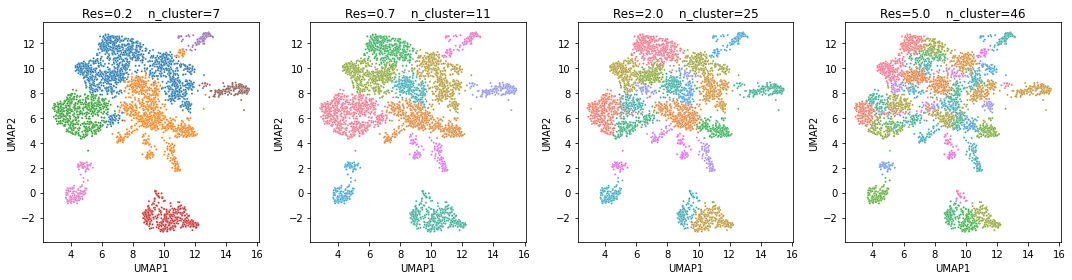

In [14]:
# Cluster visualization 
df_plot = pd.DataFrame(index=adata.obs_names, data={'UMAP1':adata.obsm['X_umap'][:,0],
                                                    'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[leiden_list+['leiden_reorder']])

plt.figure(figsize=[15,4])
for i,leiden in enumerate(leiden_list):
    # Cluster map
    plt.subplot(1,4,i+1)
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue=leiden, s=4)
    plt.legend([],[], frameon=False)
    plt.title('%s    n_cluster=%d'%(DIC_LEIDEN_NAME[leiden], len(set(df_plot[leiden]))))
    plt.tight_layout()
plt.savefig(FIG_PATH+'/LDSC_cluster.svg')
plt.savefig(FIG_PATH+'/LDSC_cluster.png')
plt.show()

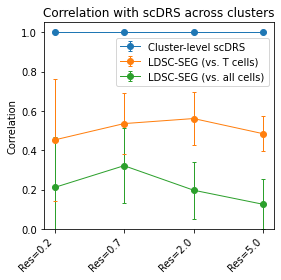

In [12]:
# Correlation across clusters
trait_list = [x for x in DIC_TRAIT_LIST['tms_facs'] if x!='UKB_460K.body_HEIGHTz']
df_corr = pd.DataFrame(index=trait_list, dtype=float)
res_list = ['cluster_lvl', 'vstcell', 'vsall']
for res in res_list:
    for leiden in leiden_list:
        df_corr['%s.%s'%(res, leiden)] = 0
    
for trait in trait_list:
    for res in res_list:
        for leiden in leiden_list:
            cluster_list = [x for x in dic_ldsc[res][trait].index if x.startswith(leiden)]
            df_plot = dic_ldsc[res][trait].loc[cluster_list].copy()
            df_plot.index = [x.split('-')[-1].replace('C','') for x in cluster_list]
            # Add scDRS results 
            temp_df = adata.obs[[leiden]]
            temp_df = temp_df.join(dic_score[ds][['%s.nlog10_pval'%trait]])
            temp_df = temp_df.groupby(leiden).agg({'%s.nlog10_pval'%trait:np.mean})
            df_plot = df_plot.join(temp_df)
            df_corr.loc[trait, '%s.%s'%(res, leiden)] = np.corrcoef(df_plot['nlog10_pval'],
                                                             df_plot['%s.nlog10_pval'%trait])[0,1]

plt.figure(figsize=[4,4])
for res in res_list:
    plot_list = ['%s.%s'%(res,x) for x in leiden_list]
    plt.errorbar(np.arange(len(plot_list)), df_corr[plot_list].mean(), 
                 yerr=df_corr[plot_list].std()/np.sqrt(df_corr.shape[0])*1.96,
                 fmt='-o', elinewidth=1, linewidth=1, capsize=2, capthick=1, label=DIC_LDSC_NAME[res])
plt.ylim([0,1.05])
plt.legend(loc='upper right', bbox_to_anchor=[1,0.95])
plt.xticks(np.arange(len(leiden_list)), [DIC_LEIDEN_NAME[x] for x in leiden_list], rotation=45, ha='right')
plt.ylabel('Correlation')
plt.title('Correlation with scDRS across clusters')
plt.tight_layout()
plt.savefig(FIG_PATH+'/LDSC_corr_across_cluster.svg')
plt.show()

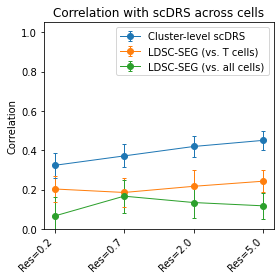

In [13]:
# Correlation across cells 
trait_list = [x for x in DIC_TRAIT_LIST['tms_facs'] if x!='UKB_460K.body_HEIGHTz']
df_corr = pd.DataFrame(index=trait_list, dtype=float)
res_list = ['cluster_lvl', 'vstcell', 'vsall']
for res in res_list:
    for leiden in leiden_list:
        df_corr['%s.%s'%(res, leiden)] = 0

for trait in trait_list:
    df_plot = adata.obs[leiden_list+['leiden_reorder']].copy()
    df_plot = df_plot.loc[dic_cell_list[ds]].copy()
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.norm_score'%trait, '%s.nlog10_pval'%trait]])
    df_plot.sort_values('%s.norm_score'%trait, ascending=True, inplace=True)

    # Add LDSC results 
    for res in res_list:
        for leiden in leiden_list:
            cluster_list = [x for x in dic_ldsc[res][trait].index if x.startswith(leiden)]
            # ldsc_nlog10p
            temp_dic = {x.split('-C')[1]:dic_ldsc[res][trait].loc[x, 'nlog10_pval'] for x in cluster_list}
            df_plot['%s.%s.nlog10_pval'%(leiden,res)] = [temp_dic[x] if x in temp_dic else 0
                                                         for x in df_plot[leiden]]
            # ldsc_coef
            temp_dic = {x.split('-C')[1]:dic_ldsc[res][trait].loc[x, 'Coefficient'] for x in cluster_list}
            df_plot['%s.%s.coef'%(leiden,res)] = [temp_dic[x] if x in temp_dic else 0
                                                  for x in df_plot[leiden]]
    
    for res in res_list:
        for leiden in leiden_list:
            df_corr.loc[trait, '%s.%s'%(res, leiden)] = np.corrcoef(df_plot['%s.%s.nlog10_pval'%(leiden,res)],
                                                                    df_plot['%s.nlog10_pval'%trait])[0,1]

plt.figure(figsize=[4,4])
for res in res_list:
    plot_list = ['%s.%s'%(res,x) for x in leiden_list]
    plt.errorbar(np.arange(len(plot_list)), df_corr[plot_list].mean(), 
                 yerr=df_corr[plot_list].std()/np.sqrt(df_corr.shape[0])*1.96,
                 fmt='-o', elinewidth=1, linewidth=1, capsize=2, capthick=1, label=DIC_LDSC_NAME[res])
plt.ylim([0,1.05])
plt.legend()
plt.xticks(np.arange(len(leiden_list)), [DIC_LEIDEN_NAME[x] for x in leiden_list], rotation=45, ha='right')
plt.ylabel('Correlation')
plt.title('Correlation with scDRS across cells')
plt.tight_layout()
plt.savefig(FIG_PATH+'/LDSC_corr_across_cells.svg')
plt.show()